In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [2]:
!pip install --upgrade -q xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 14.9 MB/s eta 0:00:0000:0100:01


In [3]:
# %config Completer.use_jedi = False  # this one very intersting it allows us to support the syntax autocomplete on pressing Tab key 

In [4]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
# from sklearn.model_seletion import train_test_split

In [5]:
print("xgboost", xgb.__version__)

xgboost 3.1.2


# Lets analys all the CSV files for the basic understanding . such as 
* *what is the significance of this csv file.* - The significane is simple that these files are for various cities on various parameters and can be used separately 
* *totol no of rows and column in each file.* - That can be seen in the analysis below as **file_summary**
* *usefullness of the values in the dataset.* - **Very useful** an can be used to do the timeseries forecsating or prediction by creating features for each file individully as per the requirement of the analysis( its presonal desire of what you want to do?)
* *if there are any missing values and what will be the impact of the missing values from that csv on the overall df for further analysis.* - **Mostly** there is no missing value in the datsets of there own but there is a csv file with all the columns and no data in it (I dont know thew use of that file. Feel free to enlighten me)

# All files basic analysis 
### SO what I have understood so far is that we have data sitting in a folder. So we need to call all the files in this folder. All the files endswith .csv

In [6]:
import os

folder_path = "/kaggle/input/hourly-energy-consumption"

file_summary = {}

for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        file_path = os.path.join(folder_path, file)
        df_temp = pd.read_csv(file_path)
        file_summary[file] = {"shape": df_temp.shape,
                             "columns": list(df_temp.columns),
            "dtypes": df_temp.dtypes.to_dict(),
            "missing_values": df_temp.isna().sum().to_dict()}

    # print(file_summary)

In [7]:
for file, summary in file_summary.items():
    print(f"\n==== {file} ====")
    print("Shape:", summary["shape"])
    print("Columns:", summary["columns"])
    print("Dtypes:", summary["dtypes"])
    print("Missing:", summary["missing_values"])


==== DOM_hourly.csv ====
Shape: (116189, 2)
Columns: ['Datetime', 'DOM_MW']
Dtypes: {'Datetime': dtype('O'), 'DOM_MW': dtype('float64')}
Missing: {'Datetime': 0, 'DOM_MW': 0}

==== EKPC_hourly.csv ====
Shape: (45334, 2)
Columns: ['Datetime', 'EKPC_MW']
Dtypes: {'Datetime': dtype('O'), 'EKPC_MW': dtype('float64')}
Missing: {'Datetime': 0, 'EKPC_MW': 0}

==== DUQ_hourly.csv ====
Shape: (119068, 2)
Columns: ['Datetime', 'DUQ_MW']
Dtypes: {'Datetime': dtype('O'), 'DUQ_MW': dtype('float64')}
Missing: {'Datetime': 0, 'DUQ_MW': 0}

==== DAYTON_hourly.csv ====
Shape: (121275, 2)
Columns: ['Datetime', 'DAYTON_MW']
Dtypes: {'Datetime': dtype('O'), 'DAYTON_MW': dtype('float64')}
Missing: {'Datetime': 0, 'DAYTON_MW': 0}

==== PJME_hourly.csv ====
Shape: (145366, 2)
Columns: ['Datetime', 'PJME_MW']
Dtypes: {'Datetime': dtype('O'), 'PJME_MW': dtype('float64')}
Missing: {'Datetime': 0, 'PJME_MW': 0}

==== PJM_Load_hourly.csv ====
Shape: (32896, 2)
Columns: ['Datetime', 'PJM_Load_MW']
Dtypes: {'Datet


# *From this output above we can see that there are 13 csv files* 
# *We don't need to join the datasets as this folder is a compilation of various datasets* 
# *So we can take any csv file and build our pridiction model for that file. So far this is my understanding of the csv files present. If it is something else please feel free to enlighten me. I would love to here more on the clarity on this data.*


*So this was good to see that we did this analysis of various csv files in the main folder as it gave me the purpose to understand that all the files are many cites like Kansas, Penselvania, and others. Hence we need to perform our prediction analysis on the main column which is PJME_hourly.csv as this is the electrical department or the board that provides energy in the USA. So it would be better if we figure out the prediction for this company in the East as PJME -> PJM-East*

In [8]:
df = pd.read_csv("../input/hourly-energy-consumption/PJME_hourly.csv")
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)

In [9]:
# Lets see botht the Head and the tail at the same time. Just for fun:-)

df_h_and_t = pd.concat([df.head(),df.tail()])
df_h_and_t

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0


In [10]:
# So if we notice that the index column is a object type lets change it to datetime so that we can you it in analysis in  better way.

pd.to_datetime(df.index)

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

### *#-Note:* 
*Post this if requiered to do some EDV exploratory data visualization. you can do it, but not today.*

# Lets start building the model 

In [11]:
# lets split the data into train and test

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [12]:
# Firat we have divided the data into train and test sets on jan 2015

train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

In [14]:
# This is intereseting just for fun 
# I check the percentile of the data and I found the following.
# that jan 1st 2015 is 78.38% of the data being used for the traing.
# Interesting right?
np.percentile(df.index, 78.38)

numpy.datetime64('2015-01-01T11:05:13.199999945')

# First: Feature Creation

In [30]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dow'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['doy'] = df.index.dayofyear
    return df

In [31]:
df = create_features(df)

In [32]:
df.head()  # just checking the new df

,PJME_MW,hour,dow,quarter,month,year,doy
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


In [33]:
from sklearn.metrics import mean_squared_error

In [35]:
train = create_features(train)
test = create_features(test)

In [37]:
features = ['hour', 'dow', 'quarter', 'month', 'year', 'doy']
target = 'PJME_MW'

In [38]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [39]:
model_reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 10)
model_reg.fit(X_train, y_train,
             eval_set = [(X_train, y_train), (X_test, y_test)],
             verbose = True)

[0]	validation_0-rmse:5179.23300	validation_1-rmse:5359.30943
[1]	validation_0-rmse:4375.01962	validation_1-rmse:4687.00132
[2]	validation_0-rmse:3874.17400	validation_1-rmse:4279.28898
[3]	validation_0-rmse:3572.89245	validation_1-rmse:4082.60841
[4]	validation_0-rmse:3372.17780	validation_1-rmse:3952.54672
[5]	validation_0-rmse:3247.62891	validation_1-rmse:3881.05746
[6]	validation_0-rmse:3162.64310	validation_1-rmse:3856.13245
[7]	validation_0-rmse:3073.82520	validation_1-rmse:3790.13994
[8]	validation_0-rmse:3021.60497	validation_1-rmse:3790.80157
[9]	validation_0-rmse:2967.30458	validation_1-rmse:3762.76936
[10]	validation_0-rmse:2888.42820	validation_1-rmse:3765.38080
[11]	validation_0-rmse:2870.15625	validation_1-rmse:3759.11653
[12]	validation_0-rmse:2813.33663	validation_1-rmse:3779.51021
[13]	validation_0-rmse:2779.04333	validation_1-rmse:3817.56184
[14]	validation_0-rmse:2760.93139	validation_1-rmse:3808.10832
[15]	validation_0-rmse:2739.22479	validation_1-rmse:3797.47445
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [43]:
figure = pd.DataFrame(data = model_reg.feature_importances_,
                        index = model_reg.feature_names_in_,
                        columns = ['importance'])

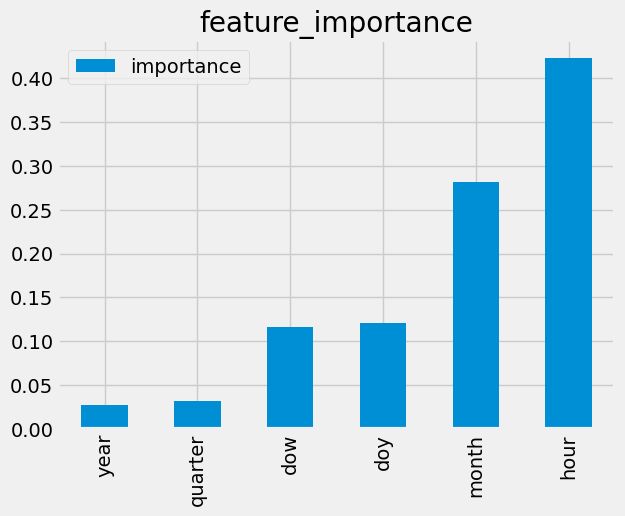

In [46]:
figure.sort_values('importance').plot(kind = 'bar', title = 'feature_importance')
plt.show()

Next that is left is to:
* predict the using the our trained model
* plot the predidtion after joining the datset
* alos, we can do hyperparameter tunning
* then we can plot the weekly predictions and we are done.

In [ ]:
# fig, ax = plt.subplots(figsize = (15, 5))
# train.plot(ax = ax, label = 'train_set')
# test.plot(ax = ax, label = 'test_set')
# plt.show()

In [ ]:
# df1 = pd.read_csv("../input/hourly-energy-consumption/AEP_hourly.csv")
# df2 = pd.read_csv("../input/hourly-energy-consumption/COMED_hourly.csv")
# df3 = pd.read_csv("../input/hourly-energy-consumption/DAYTON_hourly.csv")
# df4 = pd.read_csv("../input/hourly-energy-consumption/DEOK_hourly.csv")
# df5 = pd.read_csv("../input/hourly-energy-consumption/DOM_hourly.csv")
# df6 = pd.read_csv("../input/hourly-energy-consumption/DUQ_hourly.csv")
# df7 = pd.read_csv("../input/hourly-energy-consumption/EKPC_hourly.csv")
# df8 = pd.read_csv("../input/hourly-energy-consumption/FE_hourly.csv")
# df9 = pd.read_csv("../input/hourly-energy-consumption/NI_hourly.csv")

# df11 = pd.read_csv("../input/hourly-energy-consumption/PJMW_hourly.csv")
# df12 = pd.read_csv("../input/hourly-energy-consumption/PJM_Load_hourly.csv")
# df13 = pd.read_csv("../input/hourly-energy-consumption/pjm_hourly_est.csv")

In [ ]:
# def dataframe(df):
    
#         #we will perform a join 
#         # load the dataset as one data
        

In [ ]:
# df_test1 = pd.merge(df1, df2)

In [ ]:
# df_test2 = pd.merge(df3, df4)

In [ ]:
# df_test3 = pd.merge(df5, df6)

In [ ]:
# df_test4 = pd.merge(df7, df8)

In [ ]:
# df_test5 = pd.merge(df9, df10)

In [ ]:
# df_test6 = pd.merge(df11, df12)

In [ ]:
# df_test7 = pd.merge(df_test1, df_test2)

In [ ]:
# df_test8 = pd.merge(df_test3, df_test4)

In [ ]:
# df_test9 = pd.merge(df_test5, df_test6)

In [ ]:
# df_test10 = pd.merge(df_test7, df_test8)

In [ ]:
# df_final = pd.merge(df_test9, df_test10)

In [ ]:
# df = pd.merge(df_final , df13)